In this notebook, you will explore a Fermi-LAT extension analysis for (real) but truncated LAT data that spans nearly two-years (August 4 2021- May 3 2023) over the energies 300MeV to 2TeV for a known gamma-ray emitting source in the Milky Way Galactic plane. 

## Example Analysis of a Pulsar Wind Nebula candidate G338.2-0.0 (aka HESS J1640-645)

We are performing a [binned likelihood analysis](https://fermi.gsfc.nasa.gov/ssc/data/analysis/scitools/binned_likelihood_tutorial.html) with Fermipy using ~2-years of LAT data in the region that contains G338.2-0.0. 

To run this notebook with precomputed files, you should have the following files already in your home directory:
* ``EV*.fits where * is 0,1,2,3,4``
* ``SC00.fits``
* ``events.txt``

and your FermiPy working directory (``./data_300mev-2tev_2-year``):
* ``ltcube_0*.fits where * is 0,1,2,3``
* ``srcmdl_0*.xml where * is 0,1,2,3``
* ``srcmap_0*.fits where * is 0,1,2,3``

The inclusion of these precomputed files allows you to skip some initial calculation steps in the example analysis. When you run an analysis from scratch, some steps, especially computing the exposure (ltcube files) and source model maps (srcmdl and srcmap files), will take longer. A more detailed analysis that includes more sources and a longer interval (> 2-year) can take **much** longer. 

*FYI: Some Fermi analysis tools can take advantage of multi-threading (aka distribute the computing power across multiple cores available on your computer - makes some steps run faster). Pieces of the analysis work flow can be run separately. There are various strategies you can use to allow efficient analysis across multiple computer processors to handle a large number of sources or a more complex analysis or set of analyses.*


Verify the files exist:

In [1]:
ls ./

config_300mev-2tev_2-year.yaml
data_300mev-2tev_2-year/
EV00.fits
EV01.fits
EV02.fits
EV03.fits
EV04.fits
events.txt
lat_data_server_parameters.png
Likelihood_Analysis_with_FermiPy_Extended_Sources.ipynb
SC00.fits


In [2]:
ls data_300mev-2tev_2-year/

'300mev-2tev_exclude_4FGL J1640.7-4631e_pointsource_powerlaw_2.00_residmap.fits'
'300mev-2tev_exclude_4FGL J1640.7-4631e_pointsource_powerlaw_2.00_residmap.npy'
'300mev-2tev_exclude_4FGL J1640.7-4631e_pointsource_powerlaw_2.00_tsmap.fits'
'300mev-2tev_exclude_4FGL J1640.7-4631e_pointsource_powerlaw_2.00_tsmap.npy'
 4fgl_j1640.7-4631e_sed.fits
 4fgl_j1640.7-4631e_sed.npy
 baseline_model_00.xml
 baseline_model_01.xml
 baseline_model_02.xml
 baseline_model_03.xml
 baseline_model_counts_map_2.477_6.301.png
 baseline_model_counts_map_xproj_2.477_6.301.png
 baseline_model_counts_map_yproj_2.477_6.301.png
 baseline_model_counts_spectrum.png
 baseline_model.fits
 baseline_model_model_map_2.477_6.301.png
 baseline_model.npy
 bexpmap_00.fits
 bexpmap_01.fits
 bexpmap_02.fits
 bexpmap_03.fits
 bexpmap_roi_00.fits
 bexpmap_roi_01.fits
 bexpmap_roi_02.fits
 bexpmap_roi_03.fits
 ccube_00.fits
 ccube_01.fits
 ccube_02.fits
 ccube_03.fits
 ccube.fits
 evfile_00.txt
 evfile_01.txt
 evfile_02.txt
 evfil

### Import packages and utilities including FermiPy

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from fermipy.gtanalysis import GTAnalysis

# Make the configuration file to initiate Fermi-LAT data setup.

Complete documentation on the configuration file and available options is given in the [Configuration](http://fermipy.readthedocs.io/en/latest/config.html#config) page. fermiPy uses the [YAML](http://yaml.org/) format for its configuration files. This is a text file and you can edit it with whichever text editor you prefer.

Our file is called ```config_300mev-2tev_2-year.yaml``` and it will read like this:

```
data:
  evfile : events.txt
  scfile : SC00.fits

binning:
  roiwidth   : 10.0
  binsz      : 0.1
  binsperdec : 10

selection :
  emin : 300
  emax : 2000000
  zmax    : 100
  evclass : 128
  tmin    : 649728005.000
  tmax    : 704764805.000
  filter  : 'DATA_QUAL>0 && LAT_CONFIG==1'
  target : '4FGL J1640.7-4631e'

gtlike:
  edisp : True
  irfs : 'P8R3_SOURCE_V3'
  edisp_disable: ['isodiff', 'galdiff']

model:
  src_roiwidth : 15.0
  galdiff  : '$(CONDA_PREFIX)/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits'
  isodiff  : 'iso_P8R3_SOURCE_V3_v1.txt'
  catalogs : ['4FGL-DR3']

components:
  - { selection : { evtype : 4  } } # PSF0
  - { selection : { evtype : 8  } } # PSF1
  - { selection : { evtype : 16 } } # PSF2
  - { selection : { evtype : 32 } } # PSF3

fileio:
   outdir : data_300mev-2tev_2-year
```

## There are a few customizations you should be aware of:

1) The ```roiwidth``` is typically a 10 deg x 10 deg ROI. For larger (extended) sources (size ~ 1.0 deg or larger), a larger ROI should be used. This is connected to the ```src_roiwidth``` that we set here to 15 degrees. This means that even though our ROI will be 10 degrees, we will still model sources that extend out to 15 degrees - this is because the Fermi-LAT source confusion is very large at low energies (E < 10GeV), especially for locations that are among bright diffuse background such as the Galactic plane. Contamination from sources outside the ```roiwidth``` must be taken into account for this reason. 
    
    
2) ```binsz``` is the spatial binning per pixel. The standard is 0.1, but you can achieve more sensitive analysis by lowering the value, with the tradeoff that the analysis will take longer. 
    
    
3) FermiPy allows the latest advantage of analyzing Fermi-LAT data based on their reconstruction event quality, deemed "PSF type". This is the ```component``` section of the file. Fermi Pass 8 data is divided into four quartiles: ```PSF0, PSF1, PSF2,``` and ```PSF3```. ```PSF0``` are the photon events that have the worst angular resolution. ```PSF3``` have the best. FermiPy enables an individual binned likelihood analysis for each PSF type and then combines them to represent a summed likelihood function for the entire ROI. This treatment can also improve sensitivity and statistics for the overall analysis. 

This file is generated using the code below. 

In [4]:
config = open('config_300mev-2tev_2-year.yaml',"w")
config.close()
config = open('config_300mev-2tev_2-year.yaml',"a")
config.write("data:\n evfile : events.txt\n scfile : SC00.fits\n\n")
config.write("binning:\n roiwidth   : 10.0\n binsz      : 0.1\n binsperdec : 10\n\n") 
config.write("selection:\n emin    : 300\n emax    : 2e6\n zmax    : 100\n evclass : 128\n tmin    : 649728005.000\n tmax    : 704764805.000\n filter  : 'DATA_QUAL>0 && LAT_CONFIG==1'\n target  : '4FGL J1640.7-4631e' \n\n" )
config.write("gtlike:\n edisp : True\n irfs  : 'P8R3_SOURCE_V3'\n edisp_disable  : ['isodiff', 'galdiff']\n\n")
config.write("model:\n src_roiwidth : 15.0\n galdiff  : '$CONDA_PREFIX/share/fermitools/refdata/fermi/galdiffuse/gll_iem_v07.fits'\n isodiff  : 'iso_P8R3_SOURCE_V3_v1.txt'\n extdir   : '$CONDA_PREFIX/LAT_extended_sources_12years/Templates'\n catalogs : '4FGL-DR3'\n\n")
config.write("components:\n - { selection : { evtype : 4  } } # PSF0\n - { selection : { evtype : 8  } } # PSF1\n - { selection : { evtype : 16 } } # PSF2\n - { selection : { evtype : 32 } } # PSF3\n\n")
config.write("fileio: \n outdir : data_300mev-2tev_2-year\n\n\n")
config.close()

## Setup the object and load in the config file
We are reading in the configuration file here and configuring the analysis

In [5]:
gta = GTAnalysis('config_300mev-2tev_2-year.yaml',logging={'verbosity' : 3})

2023-05-23 18:21:14 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 1.2.0 
ScienceTools version 2.2.11


In [6]:
gta.setup()

2023-05-23 18:21:14 INFO    GTAnalysis.setup(): Running setup.
2023-05-23 18:21:14 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2023-05-23 18:21:14 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2023-05-23 18:21:14 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2023-05-23 18:21:15 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59430.000000 from DATE-OBS.
Set MJD-END to 60067.000000 from DATE-END'. [astropy.wcs.wcs]
2023-05-23 18:21:15 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2023-05-23 18:21:15 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2023-05-23 18:21:15 INFO    GTBinnedAnalysis.setup(): Running setup for component 01
2023-05-23 18:21:15 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2023-05-23 18:21:15 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2023-0

Drm_Cache::update Measured counts < 0 4FGL J1616.6-5009 37 -9.95196e-19 2.8097e-18
34.7633 38.2035 38.1303 34.7395 29.0211 22.4778 16.09 10.6712 6.58021 3.76286 2.01585 1.00219 0.46397 0.20538 0.0863618 0.0334693 0.0122759 0.00425193 0.0013826 0.000423933 0.000122819 3.34289e-05 8.46644e-06 1.98299e-06 4.33765e-07 8.83304e-08 1.67575e-08 2.97562e-09 4.99482e-10 7.96288e-11 1.20233e-11 1.71278e-12 2.29249e-13 2.86419e-14 3.21492e-15 3.31878e-16 3.17569e-17 2.8097e-18 


2023-05-23 18:23:04 INFO    GTAnalysis.setup(): Initializing source properties
2023-05-23 18:23:07 INFO    GTAnalysis.setup(): Finished setup.


# Optimizing the global source model

If we print the global source model for the ROI, you will notice that none of the spectral parameters have been calculated from the 4FGL-DR3 catalog we have selected. This can be done by running ```GTAnalysis.optimize()``` which finds the local maxima of the paramters for each source. This provides an initial fit to the global source model that we can then refine in the next step. 

In [7]:
gta.print_roi()

2023-05-23 18:24:14 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1640.7-4631e  RadialGaussian PowerLaw          0.000       nan       578.2
4FGL J1641.0-4619   PointSource    LogParabola       0.213       nan      1485.9
4FGL J1639.8-4642c  PointSource    LogParabola       0.241       nan      1235.9
4FGL J1638.1-4641c  PointSource    LogParabola       0.473       nan       558.7
4FGL J1638.5-4657c  PointSource    LogParabola       0.557       nan       723.3
4FGL J1644.5-4602c  PointSource    LogParabola       0.822       nan       626.9
4FGL J1638.4-4715c  PointSource    LogParabola       0.825       nan       598.7
4FGL J1636.9-4710c  PointSource    LogParabola       0.904       nan      1071.0
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245       nan      2268.3
4FGL J1645.8-4533c  PointSource    LogParabola       1.3

In [8]:
opt = gta.optimize()

2023-05-23 18:24:15 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['galdiff', '4FGL J1709.7-4429', 'isodiff', '4FGL J1633.0-4746e', '4FGL J1620.7-4927']
Fitting shape galdiff TS: 347181.144
Fitting shape 4FGL J1709.7-4429 TS:  15378.483
Fitting shape 4FGL J1620.7-4927 TS:   1394.387
Fitting shape 4FGL J1633.0-4746e TS:    591.189
Fitting shape 4FGL J1636.3-4731e TS:    358.690
Fitting shape 4FGL J1623.0-5004 TS:    247.986
Fitting shape 4FGL J1648.4-4611 TS:    187.279
Fitting shape 4FGL J1652.2-4633e TS:    183.961
Fitting shape 4FGL J1616.2-5054e TS:    181.535
Fitting shape 4FGL J1650.3-4600 TS:    167.006
Fitting shape isodiff TS:    131.292
Fitting shape 4FGL J1641.0-4619 TS:    109.083
Fitting shape 4FGL J1645.8-4533c TS:     96.775
Fitting shape 4FGL J1653.2-4349 TS:     94.588
Fitting shape 4FGL J1640.7-4631e TS:     92.346
Fitting shape 4FGL J1634.0-4742c TS:     74.974
Fitting shape 4FGL J1620.8-4958c TS:     72.545
Fitting shape 4FGL J1613.0-5102 TS:     64.987
Fitting shape 4FGL J1639.8-4642c TS:     59.783
Fitting shape 4FGL J

2023-05-23 18:35:14 INFO    GTAnalysis.optimize(): Finished
2023-05-23 18:35:14 INFO    GTAnalysis.optimize(): LogLike: -341507.661230 Delta-LogLike: 911.220471
2023-05-23 18:35:14 INFO    GTAnalysis.optimize(): Execution time: 659.41 s


In [13]:
gta.print_roi()

2023-05-23 18:36:44 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1640.7-4631e  RadialGaussian PowerLaw          0.000     86.78       681.4
4FGL J1641.0-4619   PointSource    LogParabola       0.213    106.19      1598.4
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     63.23      1069.7
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     46.09       686.5
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     15.12       562.2
4FGL J1636.9-4710c  PointSource    LogParabola       0.904     63.41      1302.0
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    430.87      3481.1
4FGL J1645.8-4533c  PointSource    LogParabola       1.318    105.90      1754.6
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    195.08       866.9
4FGL J1634.0-4742c  PointSource    LogParabola       1.6

The ROI summary table above gives the source catalog name, the spatial mode type, the spectral model type, the offset from the center of the region of interest (ROI) that we selected, the test statistic (TS) for the optimized fit we just ran, and the number of predicted counts (npred) for the optimized fit. 

Now we see there are initial TS values assigned to each source in the ROI. Many of them have TS values that are very low or even negative. 

### Delete sources that are not detected

The TS is defined as $TS = -2 \ln(L_0/L_s)$, where $L_0$ is the maximum likelihood of the baseline model of the region and $L_s$ is the maximum likelihood of the model with a new source included. If the added source does not improve the match of the model to the data, then $TS$ will be 0 or very small. For the models we are considering here, $TS$ is distributed like $\chi^2$, and you can use Gaussian approximation to evaluate it. The $\sqrt(TS)$ is an approximation of Gaussian width. We will talk in more detail about the method of maximum likelihood and statistical tests.

In this case, $TS = 9$ is a $\sim 3\sigma$ detection. For Fermi, we consider $TS = 25$, which is a $\sim 4\sigma$ detection, the threshold for a signficant detection. Therefore, in order to simplify the analysis, we will delete any sources with $TS < 15$ and $N_{pred} < 5$. 

In [14]:
gta.delete_sources(minmax_ts=[-1,15])
gta.delete_sources(minmax_npred=[-1,5])

[]

In [15]:
gta.print_roi()

2023-05-23 18:36:47 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1640.7-4631e  RadialGaussian PowerLaw          0.000     86.78       681.4
4FGL J1641.0-4619   PointSource    LogParabola       0.213    106.19      1598.4
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     63.23      1069.7
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     46.09       686.5
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     15.12       562.2
4FGL J1636.9-4710c  PointSource    LogParabola       0.904     63.41      1302.0
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    430.87      3481.1
4FGL J1645.8-4533c  PointSource    LogParabola       1.318    105.90      1754.6
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    195.08       866.9
4FGL J1634.0-4742c  PointSource    LogParabola       1.6

That's much better. 

Now we should improve the fit for an accurate analysis. This typically means freeing the normalizations of the brightest sources in the ROI ($TS > 25$) and for sources that are close to our source of interest, which is the center of the ROI, so we can tell FermiPy to free sources within 3.0 degree of the ROI center. We must also free both backgrounds ```isodiff``` (The unresolved isotropic diffuse emission mostly from gamma-rays from outside of our Galaxy) and ```galdiff``` (the diffuse/unresolved emission associated to gamma-rays from within our Milky Way Galaxy). 

In [16]:
# Free Normalization of all sources within 3 deg of ROI center
gta.free_sources(distance=3.0,pars='norm')

# Free sources with TS > 25
gta.free_sources(minmax_ts=[25,None],pars='norm')

# Free all parameters of isotropic and galactic diffuse components. 
#Typically this happens when you set sources within 3.0degree to be free, but just in case we do it again.
gta.free_source('galdiff')
gta.free_source('isodiff')

#Free all spectral parameters for our source of interest
gta.free_source("4FGL J1640.7-4631e",pars=['norm','Index'])

Now let's run the fit and require that it fully converge (```min_fit_quality``` should be set to 3).

In [17]:
fit = gta.fit(min_fit_quality=3)

2023-05-23 18:36:49 INFO    GTAnalysis.fit(): Starting fit.
2023-05-23 18:39:07 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2023-05-23 18:39:07 INFO    GTAnalysis.fit(): LogLike:  -341631.535 DeltaLogLike:      279.048 


The statistical fit is measured by value of LogLike:

In [18]:
print(fit['loglike'])

-341631.5349766348


On its own it is pretty worthless, but it becomes important when we want to understand how the model fit has improved from changes we have made.

Inspect the new global source model: 

In [19]:
gta.print_roi()

2023-05-23 18:39:07 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1640.7-4631e  RadialGaussian PowerLaw          0.000     82.03       725.7
4FGL J1641.0-4619   PointSource    LogParabola       0.213     93.34      1540.0
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     67.60      1139.6
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     63.06       832.4
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     15.18       579.3
4FGL J1636.9-4710c  PointSource    LogParabola       0.904    101.80      1728.2
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    383.76      3393.6
4FGL J1645.8-4533c  PointSource    LogParabola       1.318     76.27      1540.7
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    185.72       848.1
4FGL J1634.0-4742c  PointSource    LogParabola       1.6

You can also inspect the global source model broken down by source and their spectral parameters:

In [20]:
gta.print_params(True)

2023-05-23 18:39:07 INFO    GTAnalysis.print_params(): 
 idx parname                  value     error       min       max     scale free
--------------------------------------------------------------------------------
4FGL J1611.9-5125c
   0 norm                      1.49         0     1e-05     1e+03     1e-12     
   1 alpha                     2.82         0        -5         5         1     
   2 beta                     0.386         0        -2         2         1     
   3 Eb                    1.96e+03         0  1.96e+03  1.96e+03         1     
4FGL J1613.0-5102
   4 norm                     0.884     0.106     1e-05     1e+03     1e-12    *
   5 alpha                     2.55         0        -5         5         1     
   6 beta                   -0.0148         0        -2         2         1     
   7 Eb                    2.43e+03         0  2.43e+03  2.43e+03         1     
4FGL J1616.2-5054e
   8 Prefactor                 1.72     0.132     1e-05     1e+03     1e-13   

And we find the final best-fit parameters for our source of interest:

In [21]:
print(gta.roi['4FGL J1640.7-4631e'])

Name           : 4FGL J1640.7-4631e
Associations   : ['4FGL J1640.7-4631e', 'SNR G338.3-0.0', 'HESS J1640-465']
RA/DEC         :    250.180/   -46.530
GLON/GLAT      :    338.317/    -0.019
TS             : 82.03
Npred          : 725.72
Flux           : 1.356e-08 +/- 4.96e-09
EnergyFlux     : 5.193e-05 +/- 1.24e-05
SpatialModel   : RadialGaussian
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  1.842e-14 +/-   3.29e-15
b'Index'       :     -1.899 +/-     0.1234
b'Scale'       :   1.73e+04 +/-        nan


We are ready to save our best-fit model. This model will be considered our baseline (i.e., the maximized loglikelihood value measured in the fit above is now our $L_0$ as we optimize the global source model to calculate $L_s$)

In [22]:
baseline = gta.write_roi('baseline_model.npy',make_plots=True)

2023-05-23 18:39:23 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/baseline_model_00.xml...
2023-05-23 18:39:23 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/baseline_model_01.xml...
2023-05-23 18:39:23 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/baseline_model_02.xml...
2023-05-23 18:39:24 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/baseline_model_03.xml...
2023-05-23 18:39:24 INFO    GTAnalysis.write_fits(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/baseline_model.fits...
2023-05-23 18:39:34 INFO    GTAnalysis.write_roi(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2

In [23]:
ls data_300mev-2tev_2-year/*.png

data_300mev-2tev_2-year/baseline_model_counts_map_2.477_6.301.png
data_300mev-2tev_2-year/baseline_model_counts_map_xproj_2.477_6.301.png
data_300mev-2tev_2-year/baseline_model_counts_map_yproj_2.477_6.301.png
data_300mev-2tev_2-year/baseline_model_counts_spectrum.png
data_300mev-2tev_2-year/baseline_model_model_map_2.477_6.301.png
data_300mev-2tev_2-year/ft1_03_10gev-2tev_100pix_0.1deg_cmap.png
data_300mev-2tev_2-year/ft1_03_300mev-2tev_100pix_0.1deg_cmap.png
data_300mev-2tev_2-year/ps_model_counts_map_2.477_6.301.png
data_300mev-2tev_2-year/ps_model_counts_map_xproj_2.477_6.301.png
data_300mev-2tev_2-year/ps_model_counts_map_yproj_2.477_6.301.png
data_300mev-2tev_2-year/ps_model_counts_spectrum.png
data_300mev-2tev_2-year/ps_model_model_map_2.477_6.301.png


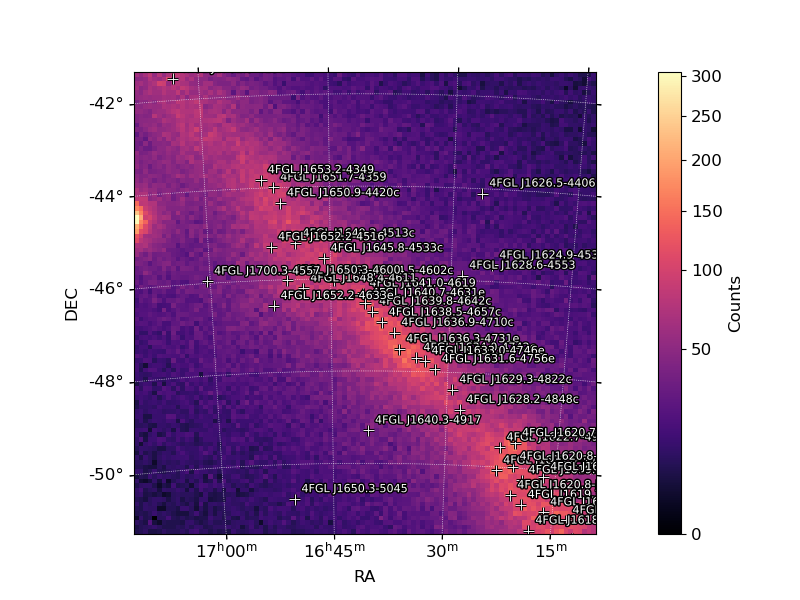

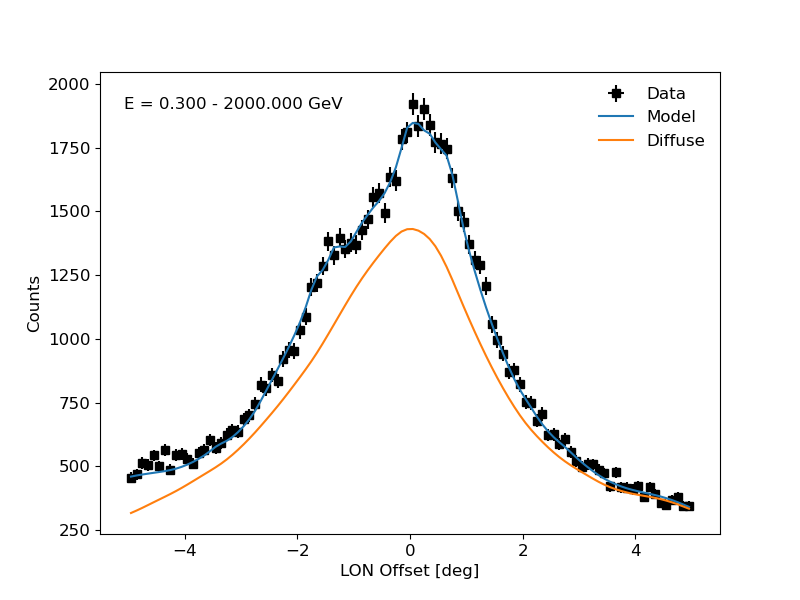

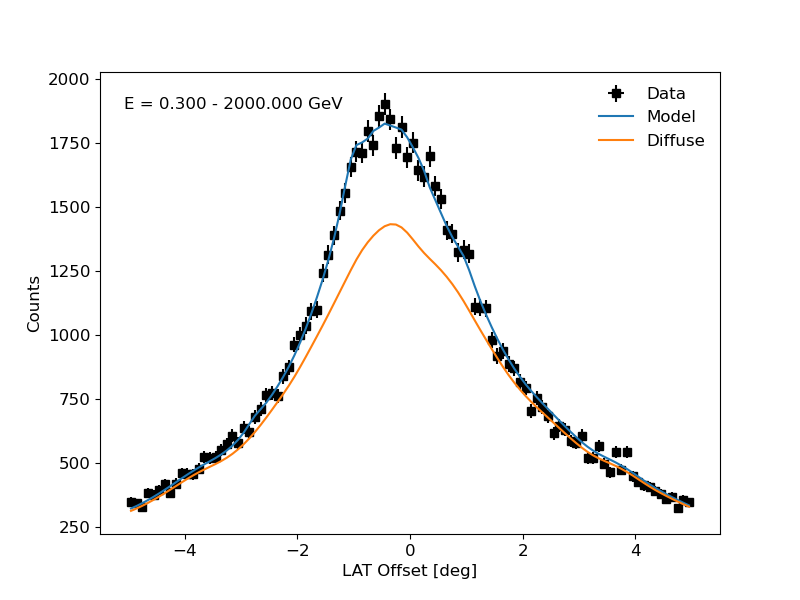

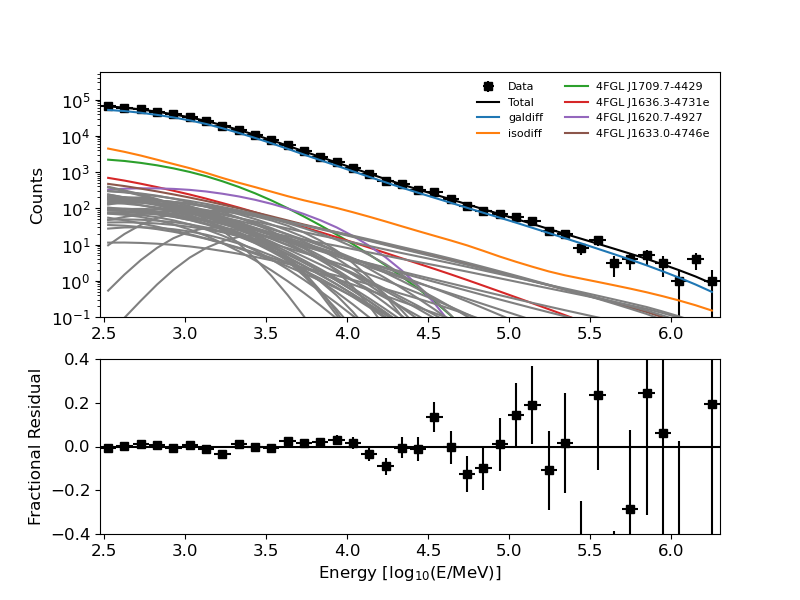

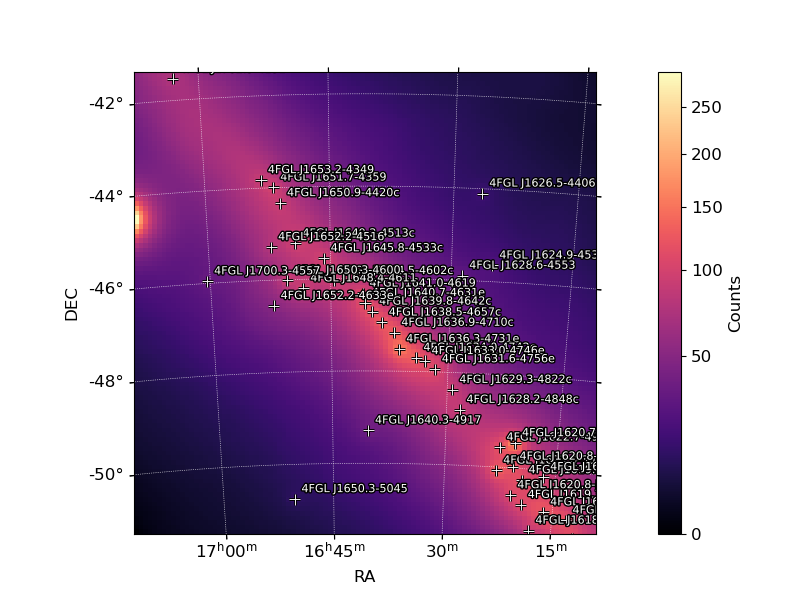

In [24]:
from IPython.display import display, Image
image_names = ['baseline_model_counts_map_2.477_6.301', 'baseline_model_counts_map_xproj_2.477_6.301', 'baseline_model_counts_map_yproj_2.477_6.301',
              'baseline_model_counts_spectrum', 'baseline_model_model_map_2.477_6.301']
for i in image_names:
    display(Image('data_300mev-2tev_2-year/%s.png'%i))

# Make a variety of maps using the model we just found

Fermi data is capable of being viewed in a variety of ways. Here are the three most basic types we will explore:
* Residual maps - plots the residual counts of the analyzed region, defined as the actual photon counts subtracted by the model predicted photon counts. This can be positive or negative depending on whether the model underpredicts or overpredicts the counts. This gives us a way to evaluate the goodness-of-fit for the model. 
* Counts maps - plots the actual photon counts of the analyzed region for a given energy range, regardless of the source model being used. This includes all emission in the region including the backgrounds.
* Test Statistics (TS) maps - plots the TS value associated to each spatial bin that has not been accounted for by the source model being used. This reveals any possible significant source emission present in the Fermi data that has not yet been modeled. 


## Residual map

In order to see the residuals modeled by our source of interest (4FGL J1640.7-4631e) we must tell gta.residmap() to exlcude this source from its calculation. We will want to do the same for the TS map. 

In [25]:
resid = gta.residmap('300mev-2tev_exclude_4FGL J1640.7-4631e',exclude=['4FGL J1640.7-4631e'],model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2023-05-23 18:39:51 INFO    GTAnalysis.residmap(): Generating residual maps
2023-05-23 18:39:51 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2023-05-23 18:40:55 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
2023-05-23 18:40:56 INFO    GTAnalysis.residmap(): Finished residual maps
2023-05-23 18:41:01 WARNING GTAnalysis.residmap(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/300mev-2tev_exclude_4FGL J1640.7-4631e_pointsource_powerlaw_2.00_residmap.npy
2023-05-23 18:41:01 INFO    GTAnalysis.residmap(): Execution time: 69.51 s


<Figure size 800x600 with 0 Axes>

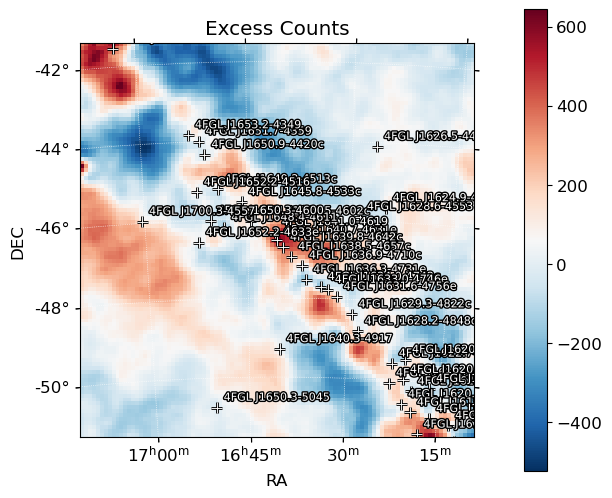

In [26]:
from fermipy.plotting import ROIPlotter
plt.clf()
fig = plt.figure(figsize=(14,6))
ROIPlotter(resid['excess'],roi=gta.roi).plot(vmin=np.min(resid['excess']),vmax=np.max(resid['excess']),subplot=122,cmap='RdBu_r')
plt.gca().set_title('Excess Counts')
plt.show()

**NOTE: AVOID USING THE SIGMA VALUES CALCULATED IN GTA.RESIDMAP() AND STORED IN THE 'SIGMA' COLUMNS. THERE IS A KNOWN ISSUE WITH OVERSIMPLIFYING THE CALCULATIONS AND IT IS BEST TO AVOID USING THAT DATA AT ALL**

We can see this discrepancy by plotting the distribution of the calculated significance (sigma) values from the data and from the Gaussian expectation. For some regions this offset is even worse!

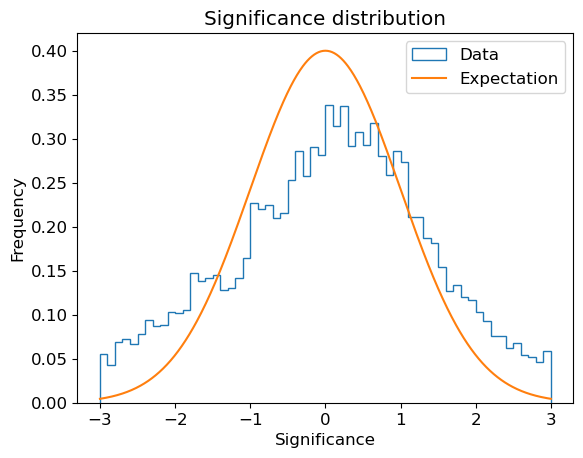

In [27]:
n, _, _ = plt.hist(resid["sigma"].data.flatten(), bins=np.linspace(-3,3,61), \
                            density=True, histtype="step", label = "Data"  )
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
x = np.linspace(-3,3, 601)
y = np.exp(-x**2 / 2.0) #gaussian with mean 0 and width 1
norm = n.sum() * 0.1 / (y.sum() * 0.01) #norm factor
plt.plot(x, norm*y, label = "Expectation")
plt.xlabel("Significance")
plt.ylabel("Frequency")
plt.title("Significance distribution")
plt.legend()
plt.show()

## Counts map

We will pick the ```PSF3``` event file ```ft1_03.fits``` to make a counts map. ```PSF3``` events are the most accurately reconstructed photon events. 

In [28]:
from gt_apps import evtbin
evtbin['evfile'] = 'data_300mev-2tev_2-year/ft1_03.fits'
evtbin['scfile'] = 'NONE'
evtbin['ebinalg'] = 'LIN'
evtbin['nxpix'] = 100
evtbin['nypix'] = 100
evtbin['binsz'] = 0.1
evtbin['coordsys'] = 'CEL'
evtbin['xref'] = gta.roi['4FGL J1640.7-4631e']['ra']
evtbin['yref'] = gta.roi['4FGL J1640.7-4631e']['dec']
evtbin['axisrot'] = 0.0
evtbin['proj'] =  'AIT'


evtbin['emin'] = 300
evtbin['emax'] = 2e6
evtbin['denergy'] = 1999700.0
evtbin['algorithm'] = 'CMAP'
evtbin['outfile'] = 'data_300mev-2tev_2-year/ft1_03_300mev-2tev_100pix_0.1deg_cmap.fits' 
evtbin.run()

evtbin['emin'] = 10e3
evtbin['emax'] = 2e6
evtbin['denergy'] = 1990000.0
evtbin['algorithm'] = 'CCUBE'
evtbin['outfile'] = 'data_300mev-2tev_2-year/ft1_03_10gev-2tev_100pix_0.1deg_cmap.fits' 
evtbin.run()

time -p gtbin evfile=data_300mev-2tev_2-year/ft1_03.fits scfile=NONE outfile=data_300mev-2tev_2-year/ft1_03_300mev-2tev_100pix_0.1deg_cmap.fits algorithm="CMAP" ebinalg="LIN" emin=300.0 emax=2000000.0 enumbins=38 denergy=1999700.0 ebinfile=NONE tbinalg="LIN" tstart=0.0 tstop=0.0 dtime=0.0 tbinfile=NONE snratio=0.0 lcemin=0.0 lcemax=0.0 nxpix=100 nypix=100 binsz=0.1 coordsys="CEL" xref=250.18 yref=-46.53 axisrot=0.0 rafield="RA" decfield="DEC" proj="AIT" hpx_ordering_scheme="RING" hpx_order=3 hpx_ebin=yes hpx_region="" evtable="EVENTS" sctable="SC_DATA" efield="ENERGY" tfield="TIME" chatter=2 clobber=yes debug=no gui=no mode="ql"
This is gtbin version HEAD
gtbin: WARNING: No spacecraft file: EXPOSURE keyword will be set equal to ontime.
real 0.84
user 0.12
sys 0.08
time -p gtbin evfile=data_300mev-2tev_2-year/ft1_03.fits scfile=NONE outfile=data_300mev-2tev_2-year/ft1_03_10gev-2tev_100pix_0.1deg_cmap.fits algorithm="CCUBE" ebinalg="LIN" emin=10000.0 emax=2000000.0 enumbins=38 denergy=19

Open the output files in DS9. It will look *something* like this: 

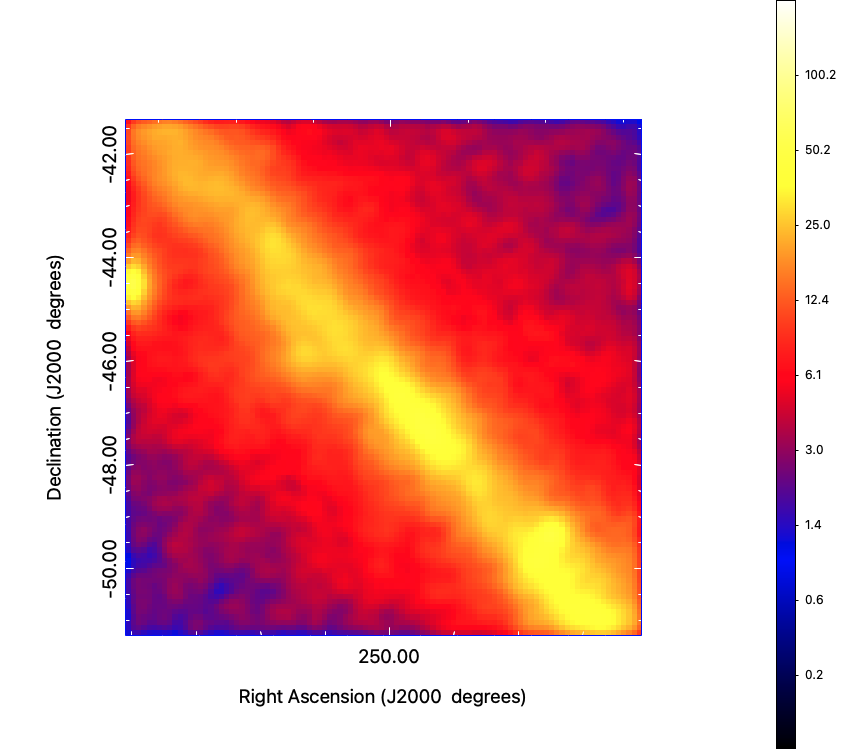

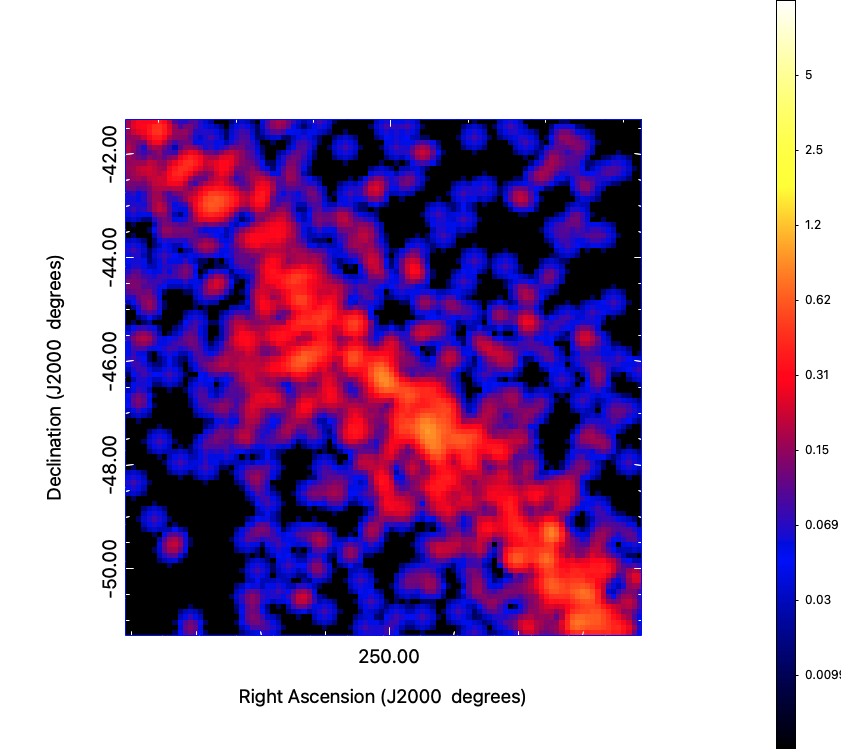

In [30]:
from IPython.display import Image
display(Image('data_300mev-2tev_2-year/ft1_03_300mev-2tev_100pix_0.1deg_cmap.png'))
display(Image('data_300mev-2tev_2-year/ft1_03_10gev-2tev_100pix_0.1deg_cmap.png'))

## TS map

In [31]:
ts = gta.tsmap('300mev-2tev_exclude_4FGL J1640.7-4631e',exclude=['4FGL J1640.7-4631e'],model={'SpatialModel' : 'PointSource', 'Index' : 2.0})

2023-05-23 18:41:31 INFO    GTAnalysis.tsmap(): Generating TS map
2023-05-23 18:43:10 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2023-05-23 18:44:08 INFO    GTAnalysis.tsmap(): Finished TS map
2023-05-23 18:44:14 WARNING GTAnalysis.tsmap(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/300mev-2tev_exclude_4FGL J1640.7-4631e_pointsource_powerlaw_2.00_tsmap.npy
2023-05-23 18:44:14 INFO    GTAnalysis.tsmap(): Execution time: 162.91 s


<Figure size 640x480 with 0 Axes>

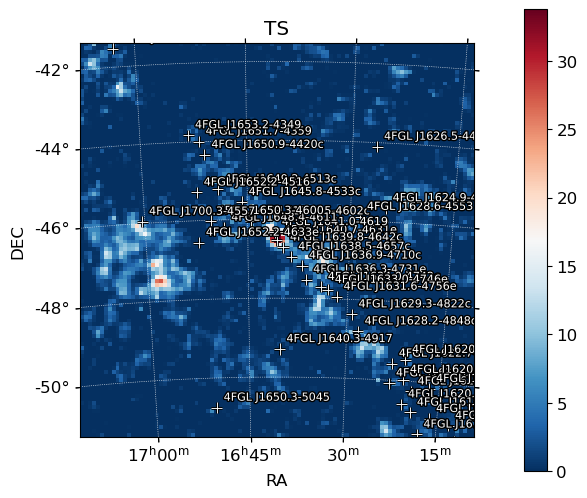

In [32]:
from fermipy.plotting import ROIPlotter
plt.clf()
fig = plt.figure(figsize=(14,6))
ROIPlotter(ts['ts'],roi=gta.roi).plot(vmin=np.min(ts['ts']),vmax=np.max(ts['ts'])/2,subplot=122,cmap='RdBu_r')
plt.gca().set_title('TS')
plt.show()

<Figure size 640x480 with 0 Axes>

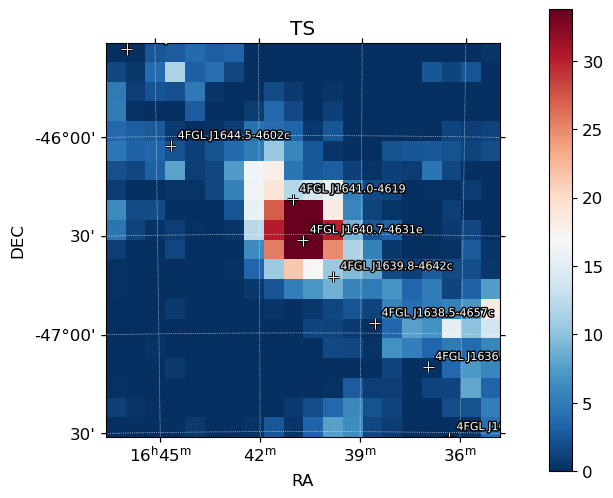

In [33]:
from fermipy.plotting import ROIPlotter
plt.clf()
fig = plt.figure(figsize=(14,6))
ROIPlotter(ts['ts'],roi=gta.roi).plot(zoom=5,vmin=np.min(ts['ts']),vmax=np.max(ts['ts'])/2,subplot=122,cmap='RdBu_r')
plt.gca().set_title('TS')
plt.show()

# Introduction to extension fitting

Our source of interest is 4FGL J1640.7-4631e. We can see from ```gta.print_roi()``` and ```print(gta.roi['4FGL J1640.7-4631e'])``` that the source is being fit using a Radial Gaussian spatial template. This corresponds to one of the two built-in spatial templates in FermiPy: Radial Disk or Gaussian. Both of these templates model extended source emission assuming a symmetric 2D shape with width parameters radius and sigma, respectively.
* The Radial Disk template assumes uniform surface brightness from R = [0,R]
* The Radial Gaussian template assumes Gaussian surface brightness distribution R = [0,sigma], where the peak is located R=0 and fades as you approach sigma. 

Important parameters to explore:
* LogLike of the global fit
* TS of 4FGL J1640.7-4631e
* TS_ext of 4FGL J1640.7-4631e, defined similar to TS, $TS_{ext} = -2 \ln(L_{ps}/L_{ext})$ where $L_{ps}$ is the point-like Loglike and $L_{ext}$ is the LogLike of the extended template (radial disk or gaussian). 

The end goal is the **maximize** all of these values for the most accurate fit to the data. 

We have the first two from the RadialGaussian fit we just completed and we print them below: 

In [34]:
print(fit['loglike'])
print(gta.roi['4FGL J1640.7-4631e']['ts'])
print(gta.roi['4FGL J1640.7-4631e']['ra'],gta.roi['4FGL J1640.7-4631e']['dec'])
print(gta.roi['4FGL J1640.7-4631e']['SpatialModel'])
print(gta.roi['4FGL J1640.7-4631e']['SpatialWidth'])

-341631.5349766348
82.0312730120495
250.18 -46.53
RadialGaussian
0.1095932641015234


Let's delete 4FGL J1640.7-4631e and test a point source or radial disk model and compare to the parameters we found using the Radial Gaussian above. This will also enable us to measure $TS_{ext}$ for both extended templates (disk and gaussian).

In [35]:
gta.delete_source('4FGL J1640.7-4631e')

2023-05-23 18:44:14 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J1640.7-4631e


Verify it has been removed from the source model. 

In [36]:
gta.print_roi()

2023-05-23 18:44:14 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1641.0-4619   PointSource    LogParabola       0.213     93.34      1540.0
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     67.60      1139.6
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     63.06       832.4
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     15.18       579.3
4FGL J1636.9-4710c  PointSource    LogParabola       0.904    101.80      1728.2
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    383.76      3393.6
4FGL J1645.8-4533c  PointSource    LogParabola       1.318     76.27      1540.7
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    185.72       848.1
4FGL J1634.0-4742c  PointSource    LogParabola       1.626    115.20      1349.5
4FGL J1650.3-4600   PointSource    PLSuperExpCuto    1.7

Add a point source back to the 4FGL J1640.7-4631e position.

In [37]:
gta.add_source('ps',{'ra' : 250.18, 'dec' : -46.53, 'SpectrumType' : 'PowerLaw', 'Index' : 2.0, 'SpatialModel' : 'PointSource'})

2023-05-23 18:44:14 INFO    GTAnalysis.add_source(): Adding source ps


In [38]:
gta.print_roi()

2023-05-23 18:45:55 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
ps                  PointSource    PowerLaw          0.000       nan       181.3
4FGL J1641.0-4619   PointSource    LogParabola       0.213     93.34      1540.0
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     67.60      1139.6
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     63.06       832.4
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     15.18       579.3
4FGL J1636.9-4710c  PointSource    LogParabola       0.904    101.80      1728.2
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    383.76      3393.6
4FGL J1645.8-4533c  PointSource    LogParabola       1.318     76.27      1540.7
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    185.72       848.1
4FGL J1634.0-4742c  PointSource    LogParabola       1.6

In [39]:
fit = gta.fit(min_fit_quality=3)

2023-05-23 18:45:55 INFO    GTAnalysis.fit(): Starting fit.
2023-05-23 18:48:09 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2023-05-23 18:48:09 INFO    GTAnalysis.fit(): LogLike:  -341631.348 DeltaLogLike:       19.770 


In [40]:
gta.print_roi()

2023-05-23 18:48:09 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
ps                  PointSource    PowerLaw          0.000     81.45       754.9
4FGL J1641.0-4619   PointSource    LogParabola       0.213     99.59      1561.2
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     69.86      1142.0
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     63.11       832.1
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     14.67       569.2
4FGL J1636.9-4710c  PointSource    LogParabola       0.904    100.67      1717.7
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    383.62      3392.6
4FGL J1645.8-4533c  PointSource    LogParabola       1.318     75.91      1536.2
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    185.77       848.3
4FGL J1634.0-4742c  PointSource    LogParabola       1.6

In [41]:
print(gta.roi['ps'])

Name           : ps
Associations   : ['ps']
RA/DEC         :    250.180/   -46.530
GLON/GLAT      :    338.317/    -0.019
TS             : 81.45
Npred          : 754.87
Flux           : 1.389e-08 +/- 2.43e-09
EnergyFlux     : 3.667e-05 +/- 6.43e-06
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  4.165e-12 +/-  7.301e-13
b'Index'       :         -2 +/-        nan
b'Scale'       :       1000 +/-        nan


In [42]:
gta.free_source('ps')

2023-05-23 18:48:09 INFO    GTAnalysis.free_source(): Freeing parameters for ps                    : ['Index']


In [43]:
fit = gta.fit(min_fit_quality=3)

2023-05-23 18:48:09 INFO    GTAnalysis.fit(): Starting fit.
/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2023-05-23 18:50:25 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2023-05-23 18:50:25 INFO    GTAnalysis.fit(): LogLike:  -341630.574 DeltaLogLike:        0.775 


In [44]:
print(gta.roi['ps'])

Name           : ps
Associations   : ['ps']
RA/DEC         :    250.180/   -46.530
GLON/GLAT      :    338.317/    -0.019
TS             : 74.54
Npred          : 527.09
Flux           : 9.484e-09 +/- 3.03e-09
EnergyFlux     : 4.414e-05 +/- 1.08e-05
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  2.897e-12 +/-  9.185e-13
b'Index'       :     -1.851 +/-     0.1023
b'Scale'       :       1000 +/-        nan


In [45]:
print(fit['loglike'])
print(gta.roi['ps']['ts'])
print(gta.roi['ps']['ra'],gta.roi['ps']['dec'])
print(gta.roi['ps']['SpatialModel'])
print(gta.roi['ps']['SpatialWidth'])

-341630.5736203365
74.53858867217787
250.18 -46.53
PointSource
None


A final step we can take is localizing the point source or allowing the location to vary. We can do this using gta.localize() to find the best-fit location and see if this can improve the fit. We set ```update = False``` since the default is set to True, and we want to be sure the point source is modeling related source emission and does not go too far away and start modeling unrelated emission somewhere else. 

In [46]:
loc = gta.localize('ps',update=False)

2023-05-23 18:50:26 INFO    GTAnalysis.localize(): Running localization for ps
2023-05-23 18:52:47 INFO    GTAnalysis._localize(): Localization succeeded.
2023-05-23 18:52:47 INFO    GTAnalysis._localize(): Localization completed with new position:
(  ra, dec) = (  250.1854 +/-   0.0191,  -46.5202 +/-   0.0187)
(glon,glat) = (  338.3270 +/-   0.0174,   -0.0149 +/-   0.0203)
offset =   0.0105 r68 =   0.0285 r95 =   0.0460 r99 =   0.0571
2023-05-23 18:52:47 INFO    GTAnalysis._localize(): LogLike:  -341631.275 DeltaLogLike:       -0.702
2023-05-23 18:52:47 INFO    GTAnalysis.localize(): Finished localization.
2023-05-23 18:52:50 WARNING GTAnalysis.localize(): Saving TS maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_loc.npy
2023-05-23 18:52:50 INFO    GTAnalysis.localize(): Execution time: 144.74 s


The localization fit was a success, but we can see the ```offset``` parameter is super small. In fact, the new position is indistinguishable from its original position within errors, so no location update is necessary anyway. 

Now let's fit and check the source model once more before saving this best-fit point source model.

In [47]:
fit = gta.fit(min_fit_quality=3)

2023-05-23 18:52:50 INFO    GTAnalysis.fit(): Starting fit.
/opt/anaconda/envs/fermi/lib/python3.9/site-packages/scipy/interpolate/_fitpack2.py:298: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)
2023-05-23 18:55:07 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2023-05-23 18:55:07 INFO    GTAnalysis.fit(): LogLike:  -341630.543 DeltaLogLike:        0.002 


In [48]:
gta.print_roi()

2023-05-23 18:55:07 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
ps                  PointSource    PowerLaw          0.000     74.62       528.1
4FGL J1641.0-4619   PointSource    LogParabola       0.213    114.18      1679.2
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     79.76      1228.0
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     62.24       826.8
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     14.86       573.1
4FGL J1636.9-4710c  PointSource    LogParabola       0.904    101.24      1723.1
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    383.43      3391.9
4FGL J1645.8-4533c  PointSource    LogParabola       1.318     75.67      1534.3
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    185.80       848.5
4FGL J1634.0-4742c  PointSource    LogParabola       1.6

In [49]:
print(gta.roi['ps'])

Name           : ps
Associations   : ['ps']
RA/DEC         :    250.180/   -46.530
GLON/GLAT      :    338.317/    -0.019
TS             : 74.62
Npred          : 528.09
Flux           : 9.567e-09 +/- 3.06e-09
EnergyFlux     : 4.454e-05 +/- 1.08e-05
SpatialModel   : PointSource
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  2.923e-12 +/-  9.269e-13
b'Index'       :     -1.851 +/-     0.1023
b'Scale'       :       1000 +/-        nan


In [50]:
point_source = gta.write_roi('ps_model.npy',make_plots=True)

2023-05-23 18:55:07 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_model_00.xml...
2023-05-23 18:55:07 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_model_01.xml...
2023-05-23 18:55:08 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_model_02.xml...
2023-05-23 18:55:08 INFO    GTBinnedAnalysis.write_xml(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_model_03.xml...
2023-05-23 18:55:09 INFO    GTAnalysis.write_fits(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_model.fits...
2023-05-23 18:55:17 INFO    GTAnalysis.write_roi(): Writing /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_model.npy...


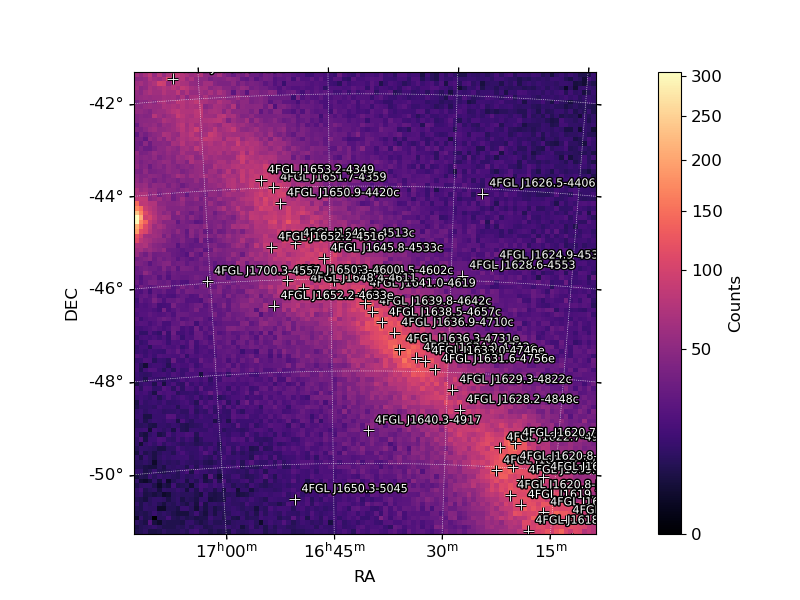

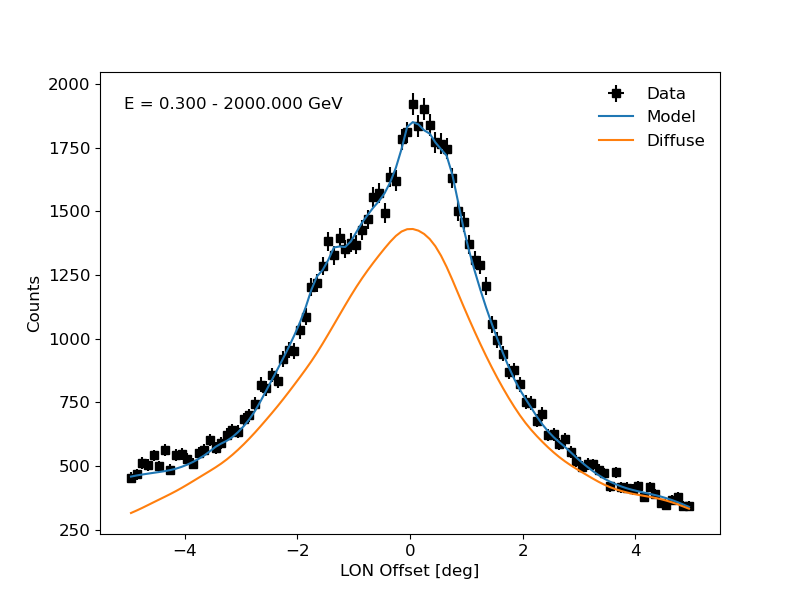

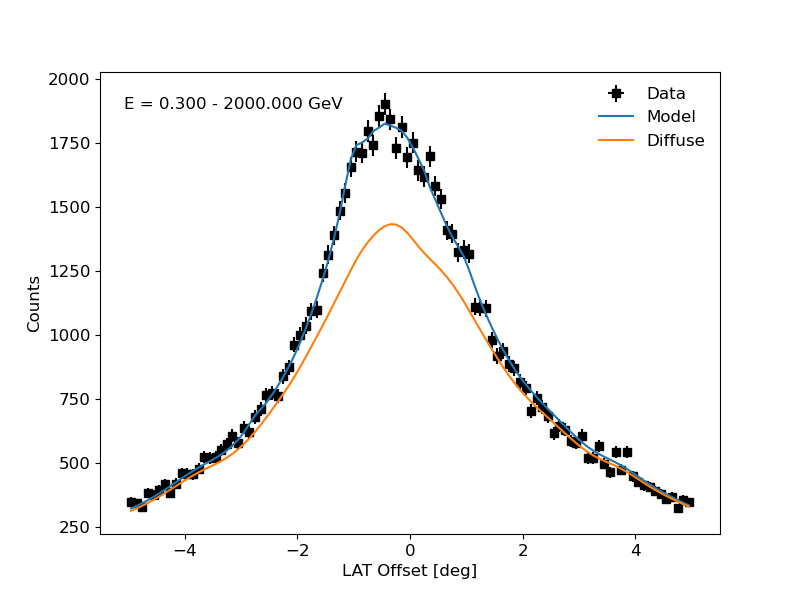

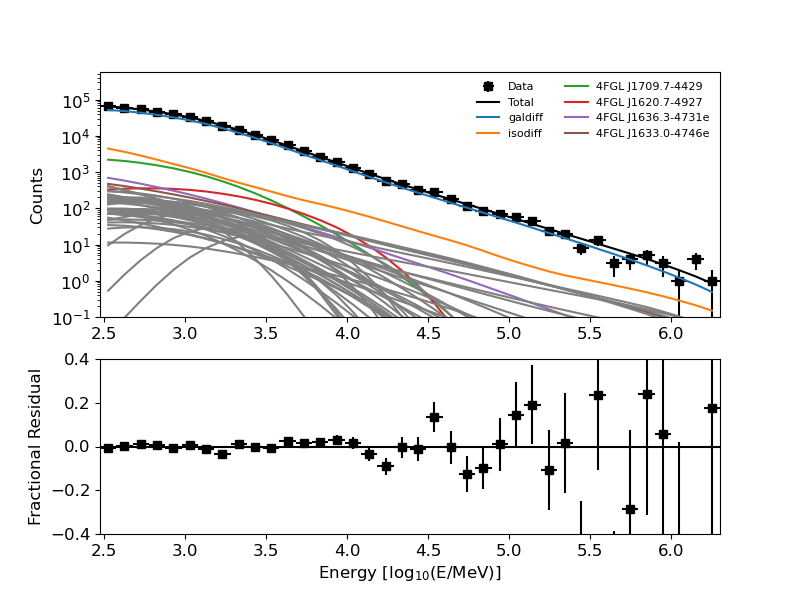

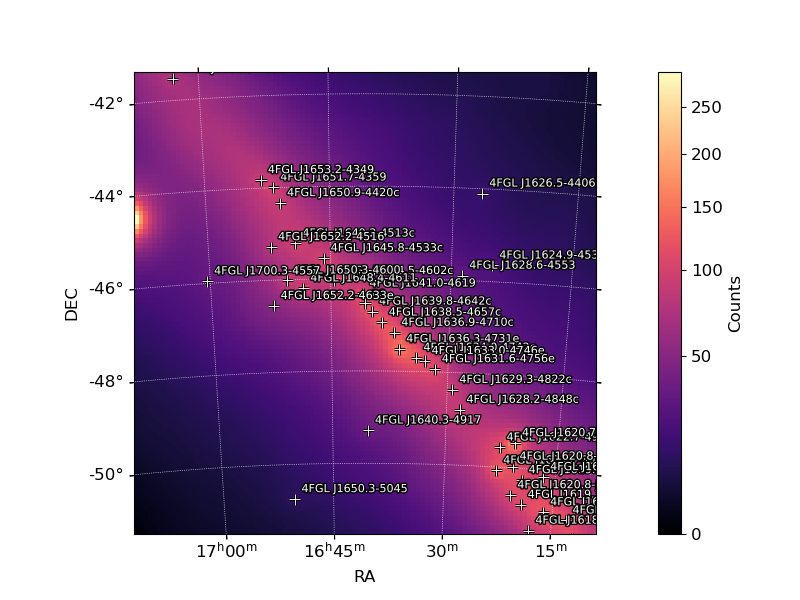

In [51]:
from IPython.display import display, Image
image_names = ['ps_model_counts_map_2.477_6.301', 'ps_model_counts_map_xproj_2.477_6.301', 'ps_model_counts_map_yproj_2.477_6.301',
              'ps_model_counts_spectrum', 'ps_model_model_map_2.477_6.301']
for i in image_names:
    display(Image('data_300mev-2tev_2-year/%s.png'%i))

# Extension tests on PS

We can run extension tests using gta.extension() on the point source we just found above. By default, the extension test is performed from a minimum width of 0.01 deg to a maximum of 1.0 deg in 21 total steps. This can be done using either the radial disk or gaussian template available in FermiPy. For most cases the default parameters are suitable for understanding evidence for any extension present. 

In [52]:
rd = gta.extension('ps',spatial_model='RadialDisk')

2023-05-23 18:55:21 INFO    GTAnalysis.extension(): Running extension fit for ps
2023-05-23 18:55:50 INFO    GTAnalysis._extension(): Fitting extended-source model.
2023-05-23 18:56:07 INFO    GTAnalysis._extension(): Generating TS map.
2023-05-23 18:58:10 INFO    GTAnalysis._extension(): Testing point-source model.
2023-05-23 18:59:54 INFO    GTAnalysis._extension(): Best-fit extension: 0.0645 + 0.0291 -    nan
2023-05-23 18:59:54 INFO    GTAnalysis._extension(): TS_ext:        0.476
2023-05-23 18:59:54 INFO    GTAnalysis._extension(): Extension UL: 0.1069
2023-05-23 18:59:54 INFO    GTAnalysis._extension(): LogLike:  -341630.328 DeltaLogLike:        0.214
2023-05-23 18:59:54 INFO    GTAnalysis.extension(): Finished extension fit.


{'spatial_model': 'RadialDisk', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}
{'spatial_model': 'RadialDisk', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': 

2023-05-23 18:59:56 WARNING GTAnalysis.extension(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_ext.npy
2023-05-23 18:59:56 INFO    GTAnalysis.extension(): Execution time: 275.47 s


{'name': 'ps', 'file': None, 'config': {'spatial_model': 'RadialDisk', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}, 'width': array([0.        , 0.01      , 0.01258925, 0.01584893, 0.01995262,
       0.02511886, 0.03162278, 0.03981072, 0.05011872, 0.06309573,
       0.07943282, 0.1       , 0.12589254, 0.15848932, 0.19952623,
       0.25118864, 0.31622777, 0.39810717, 0.50118723, 0.63095734,
       0.79432823, 1.        ]), 'dloglike': array([ 8.97614984e

A number of parameters are calculated at this step in search of a best-fit extension using the disk template. The results can be printed like so:

In [53]:
print('LogLikelihood :', rd['loglike_ext'])
print('TS_ext :', rd['ts_ext'])
print('RA,Dec J2000 in deg :', rd['ra'],rd['dec'])
print('Best-fit extension in deg :', rd['ext'])
print('Error on extension in deg :', rd['ext_err'])
print('95% upper limit on extension in deg :', rd['ext_ul95'])

LogLikelihood : -341630.32846849004
TS_ext : 0.4757447112351656
RA,Dec J2000 in deg : 250.18 -46.53
Best-fit extension in deg : 0.06450341241597277
Error on extension in deg : 0.029088095371329906
95% upper limit on extension in deg : 0.10691440803287204


This is great news, all of these values are similar to the original source 4FGL J1640.7-4631e, as they should be. Now, the radial gaussian:

In [54]:
rg = gta.extension('ps',spatial_model='RadialGaussian')

2023-05-23 18:59:56 INFO    GTAnalysis.extension(): Running extension fit for ps
2023-05-23 19:00:28 INFO    GTAnalysis._extension(): Fitting extended-source model.
2023-05-23 19:00:46 INFO    GTAnalysis._extension(): Generating TS map.
2023-05-23 19:02:51 INFO    GTAnalysis._extension(): Testing point-source model.
2023-05-23 19:04:35 INFO    GTAnalysis._extension(): Best-fit extension: 0.0485 + 0.0347 -    nan
2023-05-23 19:04:35 INFO    GTAnalysis._extension(): TS_ext:        0.366
2023-05-23 19:04:35 INFO    GTAnalysis._extension(): Extension UL: 0.1082
2023-05-23 19:04:35 INFO    GTAnalysis._extension(): LogLike:  -341630.383 DeltaLogLike:        0.192
2023-05-23 19:04:35 INFO    GTAnalysis.extension(): Finished extension fit.


{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}
{'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write

2023-05-23 19:04:38 WARNING GTAnalysis.extension(): Saving maps in .npy files is disabled b/c of incompatibilities in python3, remove the maps from the /jeagle/extended_analysis/intro_extension_analysis_example/data_300mev-2tev_2-year/ps_ext.npy
2023-05-23 19:04:38 INFO    GTAnalysis.extension(): Execution time: 281.57 s


{'name': 'ps', 'file': None, 'config': {'spatial_model': 'RadialGaussian', 'width': [], 'fit_position': False, 'width_min': 0.01, 'width_max': 1.0, 'width_nstep': 21, 'free_background': False, 'fix_shape': False, 'free_radius': None, 'fit_ebin': False, 'update': False, 'save_model_map': False, 'sqrt_ts_threshold': None, 'psf_scale_fn': None, 'make_tsmap': True, 'tsmap_fitter': 'tsmap', 'make_plots': False, 'write_fits': True, 'write_npy': True, 'reoptimize': False, 'optimizer': {'optimizer': 'MINUIT', 'tol': 0.001, 'max_iter': 100, 'init_lambda': 0.0001, 'retries': 3, 'min_fit_quality': 2, 'verbosity': 0}, 'prefix': '', 'outfile': None, 'loge_bins': []}, 'width': array([0.        , 0.01      , 0.01258925, 0.01584893, 0.01995262,
       0.02511886, 0.03162278, 0.03981072, 0.05011872, 0.06309573,
       0.07943282, 0.1       , 0.12589254, 0.15848932, 0.19952623,
       0.25118864, 0.31622777, 0.39810717, 0.50118723, 0.63095734,
       0.79432823, 1.        ]), 'dloglike': array([ 1.08104

In [55]:
print('LogLikelihood :', rg['loglike_ext'])
print('TS_ext :', rg['ts_ext'])
print('RA,Dec J2000 in deg :', rg['ra'],rg['dec'])
print('Best-fit extension in deg :', rg['ext'])
print('Error on extension in deg :', rg['ext_err'])
print('95% upper limit on extension in deg :', rg['ext_ul95'])

LogLikelihood : -341630.3832130326
TS_ext : 0.3662034363951534
RA,Dec J2000 in deg : 250.18 -46.53
Best-fit extension in deg : 0.04849679468476571
Error on extension in deg : 0.03470862631308394
95% upper limit on extension in deg : 0.10817985883332297


Again, we find consistent results. Great! 

## Understanding extension test results

Before we walk away, we should explore the widths tested in the extension test, after all, 22 values were explored and it is possible that more than one width finds a similar fit to the data. To do this, we plot the profile of the LogLikelihoods for each width tested. 

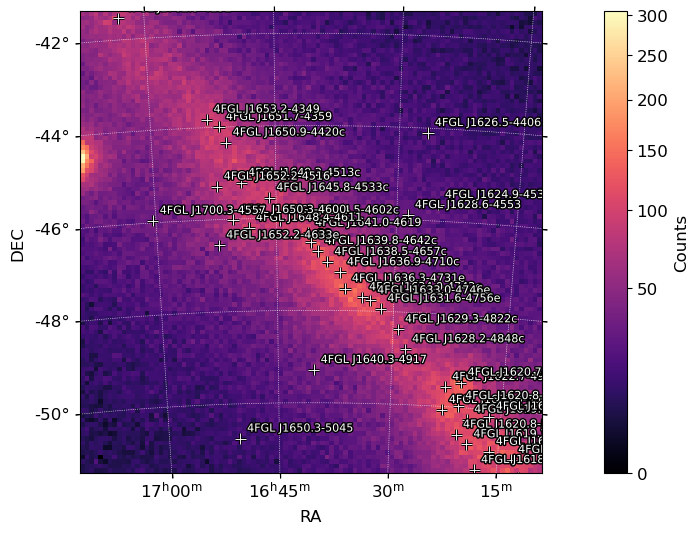

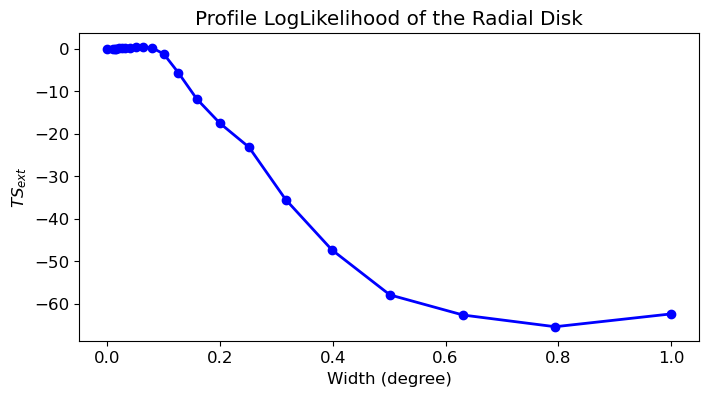

In [56]:
plt.figure(figsize=(8,4))
width = rd['width']
ts_ext = 2*rd['dloglike']
plt.plot(width,ts_ext,marker='o',color='blue',lw=2,label=r'$TS_{ext}$')
plt.title('Profile LogLikelihood of the Radial Disk')
plt.ylabel(r'$TS_{ext}$')
plt.xlabel(r'Width (degree)')
plt.show()

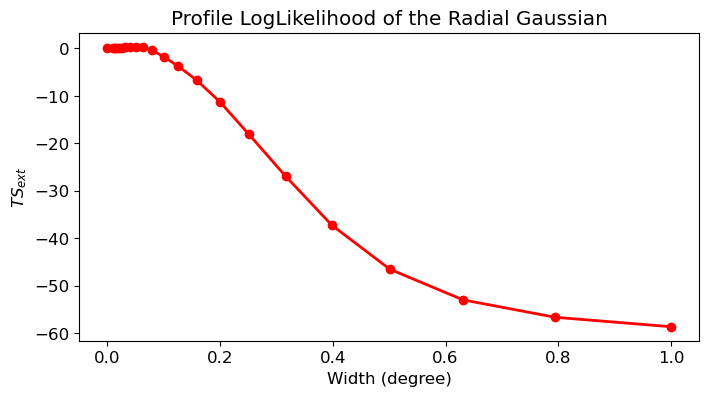

In [57]:
plt.figure(figsize=(8,4))
width = rg['width']
ts_ext = 2*rg['dloglike']
plt.plot(width,ts_ext,marker='o',color='red',lw=2,label=r'$TS_{ext}$')
plt.title('Profile LogLikelihood of the Radial Gaussian')
plt.ylabel(r'$TS_{ext}$')
plt.xlabel(r'Width (degree)')
plt.show()

The profile of the statistical fits from testing both spatial templates are pretty stable which is good. We see it really starts to drive into the negative $TS_{ext}$ at large widths. This implies that the fits to the data worsen with increasing width. It may be worth noting that at 1.0 degree width, the radial disk template shows very minor implications that the fit is starting to improve, but with $TS_{ext} \sim -50$, it is still unlikely to be better fit with a large (1 deg or larger) width. 

You might be wondering where the peak of the $TS_{ext}$ is, which should likely fall around width ~ 0.07 deg since 4FGL J1640.7-4631e is fit using this size. And the answer is that it is not present. In fact, if we consider the $TS_{ext}$ from either extension test, we see they are both < 1. This is actually telling us there is no evidence for any extension for this source in this dataset. 

In general, $TS_{ext}$ > 15 for significant evidence of extension to be found. As a cheat sheet, 4FGL J1640.7-4631e is known to be the GeV counterpart to an extended (~0.07 deg) TeV source as observed by [HESS](http://tevcat.uchicago.edu/?mode=1&showsrc=107). The motivation for modeling this source as extended was to be consistent with its HESS counterpart and not necessarily that the Fermi data indicated it. 

However, we should remember that we have only analyzed 2-years (2021-2023) of Fermi-LAT data for this region, so its more likely the extension is beyond the sensitivity of this analysis. 

# Make a spectral flux plot

These are also called spectral energy distributions (SEDs) because it literally shows the flux contribution for each energy range without you having to do any work other than view the plot. 

Let's read in the original best-fit model and calculate the SED from the source 4FGL J1640.7-4631e.

In [58]:
gta = GTAnalysis.create('data_300mev-2tev_2-year/baseline_model.npy')

2023-05-23 19:04:39 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version 1.2.0 
ScienceTools version 2.2.11
2023-05-23 19:04:40 INFO    GTAnalysis.setup(): Running setup.
2023-05-23 19:04:40 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2023-05-23 19:04:40 INFO    GTBinnedAnalysis._select_data(): Skipping data selection.
2023-05-23 19:04:40 INFO    GTBinnedAnalysis._create_ltcube(): Skipping LT Cube.
2023-05-23 19:04:40 INFO    GTBinnedAnalysis._create_expcube(): Skipping gtexpcube.
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 59430.000000 from DATE-OBS.
Set MJD-END to 60067.000000 from DATE-END'. [astropy.wcs.wcs]
2023-05-23 19:04:41 INFO    GTBinnedAnalysis._create_srcmaps(): Skipping gtsrcmaps.
2023-05-23 19:04:41 INFO    GTBinnedAnalysis.setup(): Finished setup for component 00
2023-05-23 19:04:41 INFO    GTBinnedAnalysis.setup(): Running setup for co

In [59]:
gta.print_roi()

2023-05-23 19:07:52 INFO    GTAnalysis.print_roi(): 
name                SpatialModel   SpectrumType     offset        ts       npred
--------------------------------------------------------------------------------
4FGL J1640.7-4631e  RadialGaussian PowerLaw          0.000     82.03       725.7
4FGL J1641.0-4619   PointSource    LogParabola       0.213     93.34      1540.0
4FGL J1639.8-4642c  PointSource    LogParabola       0.241     67.60      1139.6
4FGL J1638.5-4657c  PointSource    LogParabola       0.557     63.06       832.4
4FGL J1644.5-4602c  PointSource    LogParabola       0.822     15.18       579.3
4FGL J1636.9-4710c  PointSource    LogParabola       0.904    101.80      1728.2
4FGL J1636.3-4731e  RadialDisk     LogParabola       1.245    383.76      3393.6
4FGL J1645.8-4533c  PointSource    LogParabola       1.318     76.27      1540.7
4FGL J1648.4-4611   PointSource    PLSuperExpCuto    1.371    185.72       848.1
4FGL J1634.0-4742c  PointSource    LogParabola       1.6

In [60]:
print(gta.roi['4FGL J1640.7-4631e'])

Name           : 4FGL J1640.7-4631e
Associations   : ['4FGL J1640.7-4631e', 'SNR G338.3-0.0', 'HESS J1640-465']
RA/DEC         :    250.180/   -46.530
GLON/GLAT      :    338.317/    -0.019
TS             : 82.03
Npred          : 725.72
Flux           : 1.356e-08 +/- 4.96e-09
EnergyFlux     : 5.193e-05 +/- 1.24e-05
SpatialModel   : RadialGaussian
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  1.842e-14 +/-   3.29e-15
b'Index'       :     -1.899 +/-    -0.1234
b'Scale'       :   1.73e+04 +/-        nan


We only allow the source of interest and the backgrounds to remain free when measuring the flux data.

In [61]:
gta.free_sources(False)
gta.free_source('4FGL J1640.7-4631e')
gta.free_source('galdiff')
gta.free_source('isodiff')

2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1640.7-4631e    : ['Prefactor', 'Index']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1641.0-4619     : ['norm']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1639.8-4642c    : ['norm']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1638.5-4657c    : ['norm']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1644.5-4602c    : ['norm']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1636.9-4710c    : ['norm']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1636.3-4731e    : ['norm']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1645.8-4533c    : ['norm']
2023-05-23 19:07:52 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1648.4-4611     : ['Prefactor']


In [62]:
fit = gta.fit(min_fit_quality=3)

2023-05-23 19:07:52 INFO    GTAnalysis.fit(): Starting fit.
2023-05-23 19:07:54 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2023-05-23 19:07:54 INFO    GTAnalysis.fit(): LogLike:  -341631.535 DeltaLogLike:        0.000 


In [63]:
print(gta.roi['4FGL J1640.7-4631e'])

Name           : 4FGL J1640.7-4631e
Associations   : ['4FGL J1640.7-4631e', 'SNR G338.3-0.0', 'HESS J1640-465']
RA/DEC         :    250.180/   -46.530
GLON/GLAT      :    338.317/    -0.019
TS             : 82.23
Npred          : 726.05
Flux           : 1.357e-08 +/- 3.09e-09
EnergyFlux     : 5.193e-05 +/- 1.26e-05
SpatialModel   : RadialGaussian
SpectrumType   : PowerLaw
Spectral Parameters
b'Prefactor'   :  1.842e-14 +/-  3.216e-15
b'Index'       :     -1.899 +/-    0.09537
b'Scale'       :   1.73e+04 +/-        nan


In [64]:
sed = gta.sed('4FGL J1640.7-4631e',free_background=True, loge_bins=gta.log_energies[::5])

2023-05-23 19:07:54 INFO    GTAnalysis.sed(): Computing SED for 4FGL J1640.7-4631e
2023-05-23 19:07:54 INFO    GTAnalysis._make_sed(): Fitting SED
2023-05-23 19:07:54 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1640.7-4631e    : ['Index']
2023-05-23 19:07:54 INFO    GTAnalysis.free_source(): Fixing parameters for galdiff               : ['Index']
2023-05-23 19:07:54 INFO    GTAnalysis.free_source(): Fixing parameters for 4FGL J1640.7-4631e    : ['Prefactor']
2023-05-23 19:08:27 INFO    GTAnalysis.sed(): Finished SED
2023-05-23 19:08:32 INFO    GTAnalysis.sed(): Execution time: 38.03 s


In [65]:
source = gta.roi.get_source_by_name('4FGL J1640.7-4631e')
np.set_printoptions(precision=5)
E = np.array(source['model_flux']['energies'])
dnde = np.array(source['model_flux']['dnde'])
dnde_hi = np.array(source['model_flux']['dnde_hi'])
dnde_lo = np.array(source['model_flux']['dnde_lo'])
e_min = np.array(10**gta.log_energies[::5][:-1])
e_max = np.array(10**gta.log_energies[::5][1:])

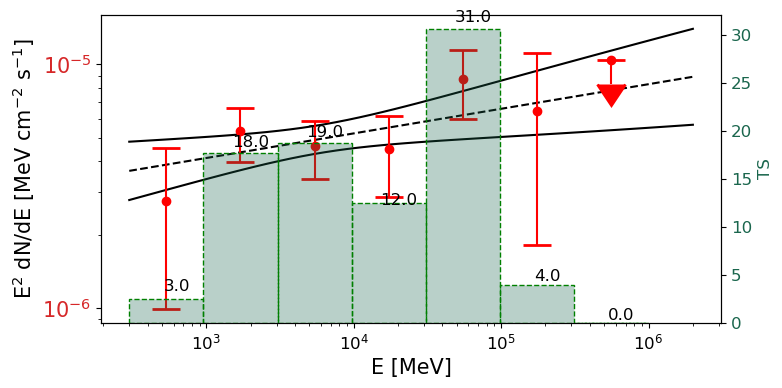

In [66]:
plt.figure(figsize=(8,4))
plt.loglog(E, (E**2)*dnde, 'k--')
plt.loglog(E, (E**2)*dnde_hi, 'k')
plt.loglog(E, (E**2)*dnde_lo, 'k')
ax1 = plt.subplot(111)
ax1.set_xlabel('E [MeV]',size=15)
ax1.set_ylabel(r'E$^{2}$ dN/dE [MeV cm$^{-2}$ s$^{-1}$]',size=15)
for n in range(7):
            if sed['ts'][n] > 1.0:
                        ax1.errorbar(np.array(sed['e_ctr'][n]), sed['e2dnde'][n], yerr=sed['e2dnde_err'][n], fmt ='o', color='red',capsize=10,capthick=2)
            if sed['ts'][n] < 1.0:
                        ax1.errorbar(np.array(sed['e_ctr'][n]),sed['e2dnde_ul95'][n], yerr=0.2*sed['e2dnde_ul95'][n], fmt='o', uplims=True, color='red',capsize=10,capthick=2)
color = 'tab:red'
ax1.tick_params(axis='y', labelcolor=color,labelsize=15)
ax2 = ax1.twinx()
fc = (0.1, 0.4, 0.3)
ax2.set_ylabel('TS', color=fc)
width= np.array(e_max-e_min)
bins = (e_max+e_min)/2
ax2.bar(bins, sed['ts'], width=width, edgecolor='green', ls='dashed', fc=(0.1, 0.4, 0.3, 0.3))
ax2.tick_params(axis='y', labelcolor=fc)
rects = sed['ts']
labels = ["label%d" % i for i in range(len(rects))]

#print TS on top of the bars.
np.set_printoptions(precision=2)
s = np.around(sed['ts'])
n = bins
for i in range(len(s)):
            ax2.annotate(str(s[i]), xy=(n[i],s[i]), va= 'bottom', ha='center')

plt.show()
#plt.savefig('whatever_you_want_to_name_it.png')